In [3]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [4]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [5]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()
transcriptomics_columns = CPTAC.get_transcriptomics_cols()

#print(transcriptomics_columns)
#print(transcriptomics)

In [13]:
#List of some known interacting proteins
siteList = ['RUNX1','EZH2','TP53','ARID1B','BAF250B','SMARCA4','BRG1','BAF190A','SMARCA2','BRM','BAF190B','SMARCE1','ACTL6A','BAF53','SMARCC1','BAF155','SMARCC2','BAF170','SMARCB1','SNF5','BAF47','PHF10','SMARCA1','SMARCD1','SMARCD2','PTEN']

### Look through our list of sites, test for difference in transcriptomics levels when ARID1A is mutated

In [14]:
p_values = []
site_names = []
gene = 'ARID1A'

'''Perform a T-Test comparing transcriptomics levels when ARID1A is mutated vs wildtype, in tumor patients only'''
for site in siteList:
    if site in transcriptomics_columns:
        transdf = CPTAC.compare_mutations(transcriptomics, site, gene)
        transdf = transdf.loc[transdf["Patient_Type"] == "Tumor"]
        #print(transdf)
        wtdf = transdf.loc[transdf["Mutation"] == "Wildtype"]
        mutateddf = transdf.loc[transdf["Mutation"] != "Wildtype"]
        ttest = scipy.stats.ttest_ind(wtdf[site], mutateddf[site])
        p_values.append(ttest[1])
        site_names.append(site)


In [15]:
print(p_values)
print(site_names)

[0.7953490953394979, 0.01691587874891732, 0.00037328494313790787, 0.11980410049941591, 0.08331786938299397, 0.3468718377354182, 0.1045719604803765, 0.6272594654680055, 0.023700667818382565, 0.020919918961459713, 0.07811538963255547, 0.033210003634131194, 0.01618915206269221, 0.6183649357739911, 0.029864387341232635, 0.0742932465349621]
['RUNX1', 'EZH2', 'TP53', 'ARID1B', 'SMARCA4', 'SMARCA2', 'SMARCE1', 'ACTL6A', 'SMARCC1', 'SMARCC2', 'SMARCB1', 'PHF10', 'SMARCA1', 'SMARCD1', 'SMARCD2', 'PTEN']


### Adjust for multiple testing using Bonferroni correction

In [23]:
bonferroniCutoff = .05/ len(site_names)
print(bonferroniCutoff)

significantSites = []
significantPvals = []

for i in range(0, len(p_values)):
    if p_values[i] <= bonferroniCutoff:
        significantPvals.append(p_values[i])
        significantSites.append(site_names[i])


0.003125


In [24]:
#Print off significant sites
print(significantSites)

['TP53']


In [25]:
#Print off significant p_values
print(significantPvals)

[0.00037328494313790787]


In [26]:
#Make a dict of sites-p-values

bfSignificantVals = dict(zip(significantSites, significantPvals))
print(bfSignificantVals)

{'TP53': 0.00037328494313790787}


### Plot the significant sites, Mutated vs Wildtype in cancer patients

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


[Text(0, 0.5, 'Transcriptomics'), Text(0.5, 0, 'Mutation')]

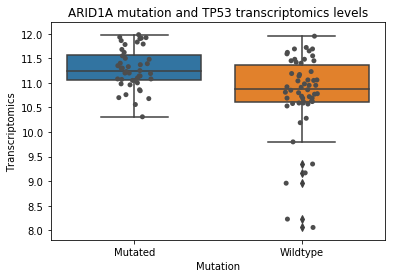

In [27]:
gene = "ARID1A"
site = "TP53"

genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)


for i, row in genedf.iterrows():
    id = i
    if row['Mutation'] != 'Wildtype':
        genedf.set_value(id,'Mutation','Mutated')

phos_boxplot = sns.boxplot(data=genedf, x="Mutation",y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Transcriptomics")

### Plot significant sites, look at all mutations

[Text(0, 0.5, 'Transcriptomics'), Text(0.5, 0, 'Mutation Type')]

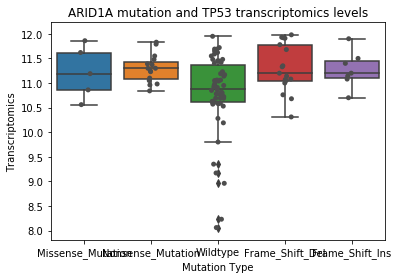

In [28]:

genedf = CPTAC.compare_mutations(transcriptomics, site, gene)
genedf = genedf.loc[genedf["Patient_Type"] == "Tumor"].drop("Patient_Type", axis = 1)
#print(genedf)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation",y=site)
phos_boxplot.set_title(gene + " mutation and " + site + " transcriptomics levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation Type",ylabel="Transcriptomics")